In [7]:
# comparing price and bid amount
import matplotlib.pyplot as plt
import pandas as pd

optimalBidAmount_reg = pd.read_csv("/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/optimizedBidAmount_regular_28day_weekly_opt.csv")
optimalBidAmount_flex = pd.read_csv("/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/optimizedBidAmount_flex_28day_weekly_opt.csv")
EOM_price = pd.read_csv("/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/2016/EOM_Prices.csv")
industry_demand = pd.read_csv("/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/input/2016/industrial_demand.csv")
industry_demand = pd.DataFrame(industry_demand)
industry_demand['timestep'] = optimalBidAmount_reg['timestep']
industry_demand = industry_demand[0:len(EOM_price)]
PFC = pd.read_csv("/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/PFC_export.csv")
PFC['timestep'] = optimalBidAmount_reg['timestep']
PFC = PFC[0:len(EOM_price)]

# Convert variables to lists
optimalBidAmount_reg = optimalBidAmount_reg['bidQuantity'].tolist()
optimalBidAmount_flex = optimalBidAmount_flex['bidQuantity'].tolist()
EOM_price = EOM_price['Price'].tolist()
industry_demand = industry_demand['industry'].tolist()
PFC = PFC['PFC'].tolist()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18))

ax1.plot(EOM_price, label='EOM_price')
ax1.plot(PFC, label='PFC')
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.set_title('PFC and EOM_price')

ax2.plot(optimalBidAmount_reg, color='red', label='optimalBidAmount_reg')
ax2.set_ylabel('bidQuantity MW')
ax2.set_title('optimalBidAmount_reg')

ax3.plot(optimalBidAmount_flex, color='green', label='optimalBidAmount_flex')
ax3.set_xlabel('Index')
ax3.set_ylabel('bidQuantity MW')
ax3.set_title('optimalBidAmount_flex')

fig.legend(loc='upper right')
plt.show()

KeyError: 'timestep'

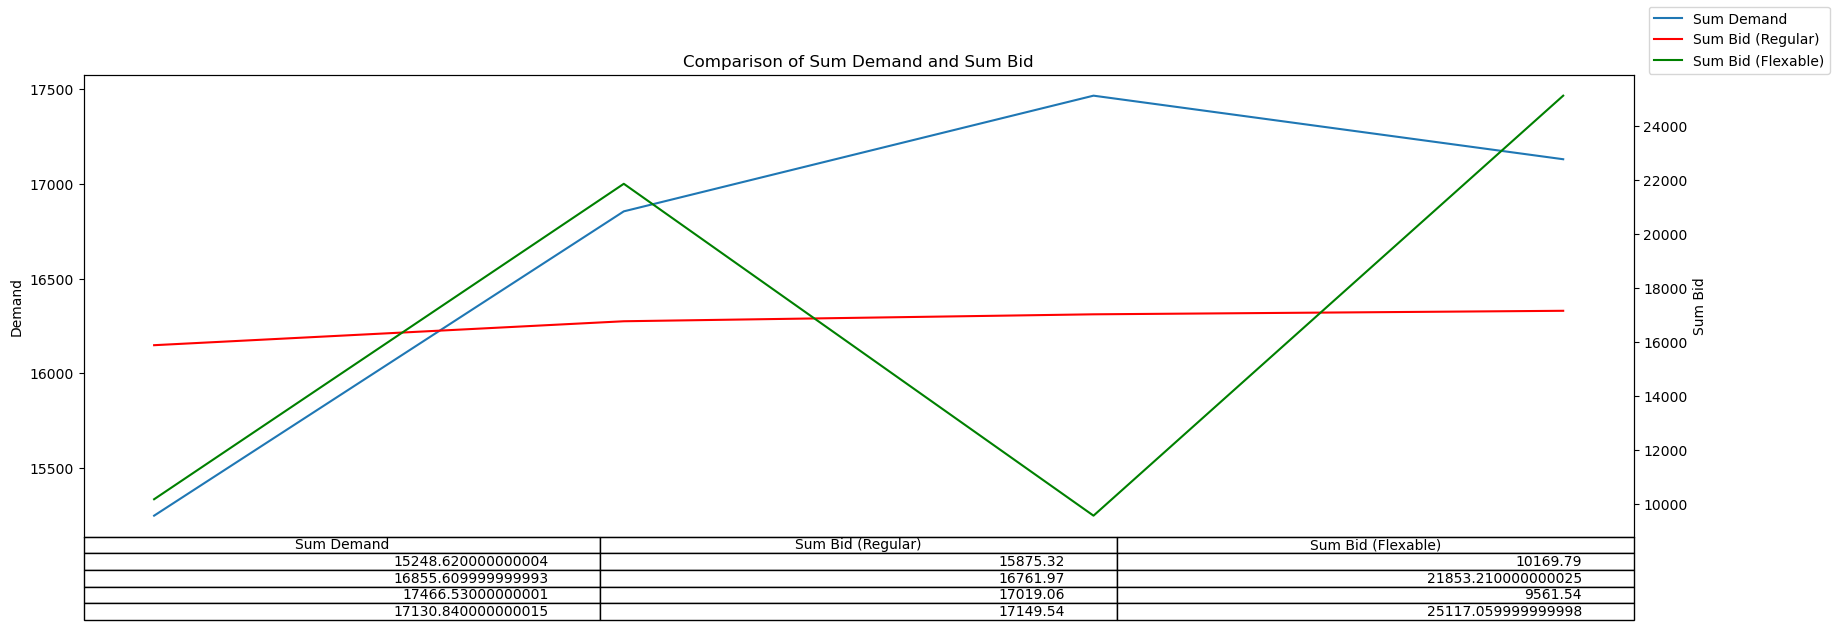

In [2]:
#comparing weekly demand and bid sums
sum_demand = []
sum_bid_flex = []
sum_bid_reg = []

foresight = int(168/0.25)

optimalBidAmount_reg['Week'] = optimalBidAmount_reg['timestamp'].dt.isocalendar().week
unique_weeks = optimalBidAmount_reg['Week'].unique()
for week in unique_weeks:
    # Extract data for the current week
    interval_demand = industry_demand[industry_demand['Week'] == week]
    interval_demand = list(interval_demand['industry'])
    weeklyIntervalPFC = PFC[PFC['Week'] == week]
    weeklyIntervalPFC = list(weeklyIntervalPFC['price'])
    optimalBidamount, currentSOC = optimizeH2Prod(price=weeklyIntervalPFC, industry_demand=weeklyIntervalDemand, mode=mode)
    allBidQuantity.extend(optimalBidamount)
    allCurrentSOC.extend(currentSOC)
    
interval_count = len(EOM_price) // foresight
for interval in range(interval_count):
    start_idx = interval * foresight #start point for time interval
    end_idx = (interval + 1) * foresight #start point for time interval
    interval_demand = industry_demand[start_idx:end_idx]
    interval_bidQuantity_reg = optimalBidAmount_reg[start_idx:end_idx] #setting intervals for price
    interval_bidQuantity_flex = optimalBidAmount_flex[start_idx:end_idx]
    
    sum_demand.append(sum(interval_demand))
    sum_bid_reg.append(sum(interval_bidQuantity_reg))
    sum_bid_flex.append(sum(interval_bidQuantity_flex))

fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.plot(sum_demand, label='Sum Demand')
ax1.set_xlabel('Index')
ax1.set_ylabel('Demand')
ax1.set_title('Comparison of Sum Demand and Sum Bid')

ax2 = ax1.twinx()
ax2.plot(sum_bid_reg, color='red', label='Sum Bid (Regular)')
ax2.plot(sum_bid_flex, color='green', label='Sum Bid (Flexable)')
ax2.set_ylabel('Sum Bid')

fig.legend(loc='upper right')

# Create a data table
data = {'Sum Demand': sum_demand, 'Sum Bid (Regular)': sum_bid_reg, 'Sum Bid (Flexable)': sum_bid_flex}
columns = ['Sum Demand', 'Sum Bid (Regular)', 'Sum Bid (Flexable)']
df = pd.DataFrame(data)

# Display the data table
ax2.table(cellText=df.values, colLabels=columns, loc='bottom')

plt.show()

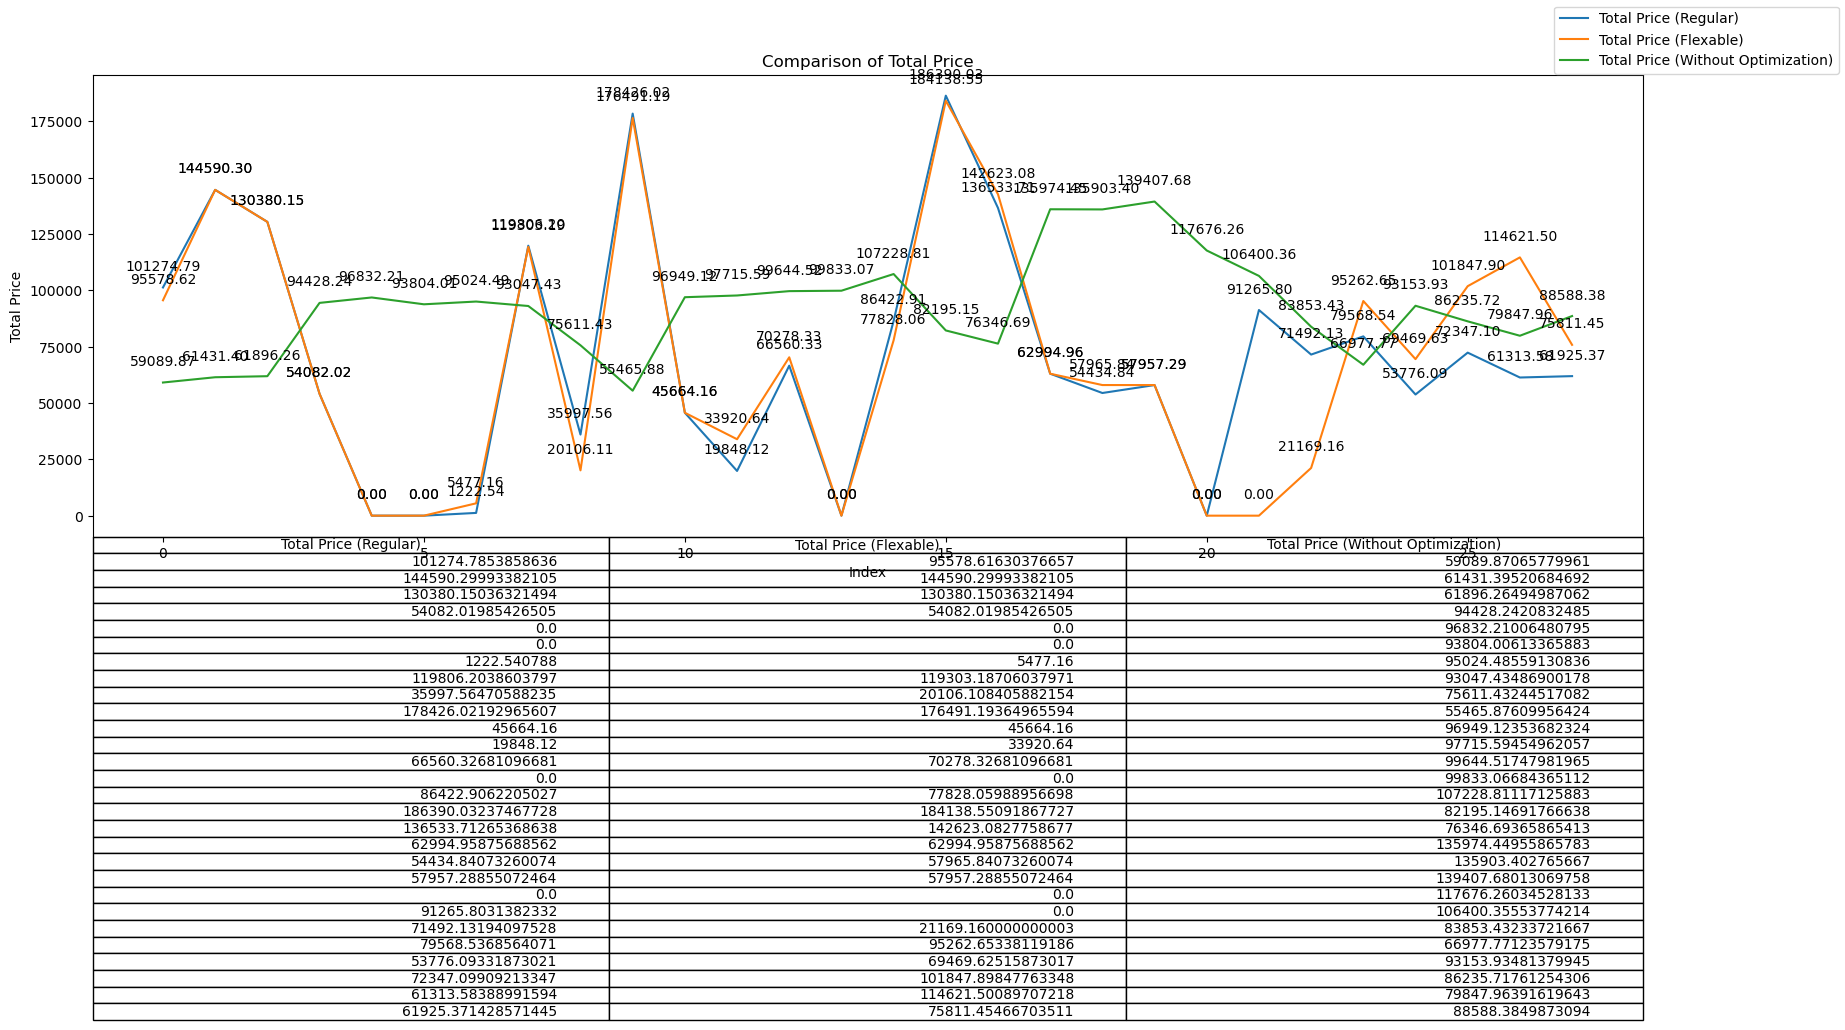

In [8]:
#Energy price check using EOM prices

total_price_flex = []
total_price_reg = []
total_price_wo_opt = []

interval_count = len(EOM_price) // foresight
for interval in range(interval_count):
    start_idx = interval * foresight #start point for time interval
    end_idx = (interval + 1) * foresight #start point for time interval
    interval_bidQuantity_reg = pd.to_numeric(optimalBidAmount_reg[start_idx:end_idx]) # convert to numeric
    interval_bidQuantity_wo_opt = pd.to_numeric(industry_demand[start_idx:end_idx]) # convert to numeric
    interval_bidQuantity_flex = pd.to_numeric(optimalBidAmount_flex[start_idx:end_idx]) # convert to numeric
    interval_price = pd.to_numeric(EOM_price[start_idx:end_idx]) # convert to numeric
    
    
    interval_total_price_reg = sum((qty * p for qty, p in zip(interval_bidQuantity_reg, interval_price))) 
    interval_total_price_flex = sum((qty * p for qty, p in zip(interval_bidQuantity_flex, interval_price)))
    interval_total_price_wo_opt = sum((qty * p for qty, p in zip(interval_bidQuantity_wo_opt, interval_price)))

    total_price_reg.append(interval_total_price_reg)
    total_price_flex.append(interval_total_price_flex)
    total_price_wo_opt.append(interval_total_price_wo_opt)
    

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(total_price_reg, label='Total Price (Regular)')
ax.plot(total_price_flex, label='Total Price (Flexable)')
ax.plot(total_price_wo_opt, label='Total Price (Without Optimization)')

ax.set_xlabel('Index')
ax.set_ylabel('Total Price')
ax.set_title('Comparison of Total Price')

# Add data labels with vertical spacing
for i, price in enumerate(total_price_reg):
    ax.annotate(f'{price:.2f}', (i, price), textcoords="offset points", xytext=(0,10), ha='center', va='bottom')

for i, price in enumerate(total_price_flex):
    ax.annotate(f'{price:.2f}', (i, price), textcoords="offset points", xytext=(0,10), ha='center', va='bottom')

for i, price in enumerate(total_price_wo_opt):
    ax.annotate(f'{price:.2f}', (i, price), textcoords="offset points", xytext=(0,10), ha='center', va='bottom')

fig.legend(loc='upper right')

# Create a data table
data = {'Total Price (Regular)': total_price_reg, 'Total Price (Flexable)': total_price_flex, 'Total Price (Without Optimization)': total_price_wo_opt}
columns = ['Total Price (Regular)', 'Total Price (Flexable)', 'Total Price (Without Optimization)']
df = pd.DataFrame(data)

# Display the data table
ax.table(cellText=df.values, colLabels=columns, loc='bottom')

plt.show()

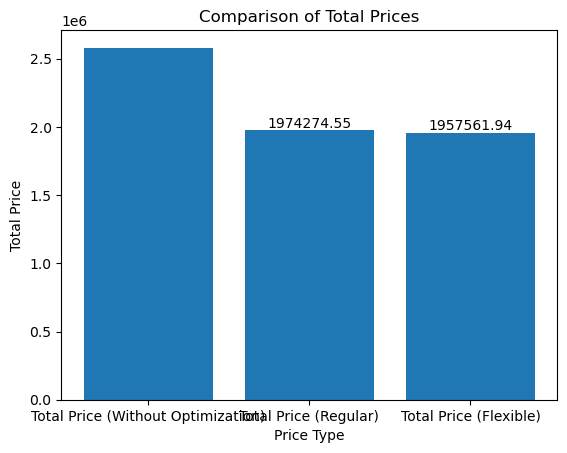

In [9]:
#Price check
total_price_wo_opt = sum(total_price_wo_opt)
total_price_reg = sum(total_price_reg)
total_price_flex = sum(total_price_flex)
difference_flx =  total_price_wo_opt - total_price_flex
difference_reg = total_price_wo_opt - total_price_reg

import matplotlib.pyplot as plt

# Define the data
labels = ['Total Price (Without Optimization)', 'Total Price (Regular)', 'Total Price (Flexible)']
values = [total_price_wo_opt, total_price_reg, total_price_flex]

# Define the tooltips
tooltips = [f'Total Price (Regular): {total_price_reg:.2f}', f'Total Price (Flexible): {total_price_flex:.2f}']

# Create the bar graph
plt.bar(labels, values)

# Add tooltips above total_price_reg and total_price_flex
for i, v in enumerate(values[1:]):
    plt.text(i+1, v, f'{v:.2f}', ha='center', va='bottom')

# Set the title and labels
plt.title('Comparison of Total Prices')
plt.xlabel('Price Type')
plt.ylabel('Total Price')

# Display the plot
plt.show()